# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [3]:
data_df = pd.read_csv("files/hw2_out.csv", sep="\t", header=0, index_col="twitter_id")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы.

In [4]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("YOUR_TECHNOSFERA_USER_NAME") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу:

In [5]:
class Clustering:
    """
    Implement clustering algorithm according 
    """
    
    def __init__(self, k, max_iter=100, n_init=1, epsilon=1e-3):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.clust = sc.MiniBatchKMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, tol=epsilon)
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.clust.fit(x, y)
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return self.clust.predict(x)
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

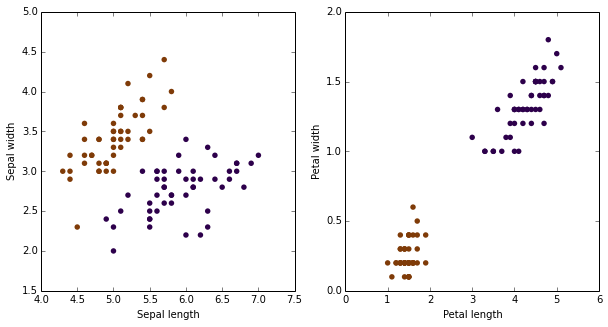

In [6]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам.

In [7]:
pred_iris = Clustering(2).fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:2507: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция
- Средний диаметр или радиус кластера
- Sihouette

In [8]:
def quality(x, y):
    """
    Implement quality criterion of your choice
    """
    clusters = np.unique(y)
    inertia = 0
    for cluster in clusters:
        x_c = x[y == cluster]
        centriod = x_c.mean(axis=0)
        
        for x_i in x_c:
            inertia += ss.distance.euclidean(centriod, x_i)**2
    
    return inertia

Применить критерий для выбора параметров алгоритма

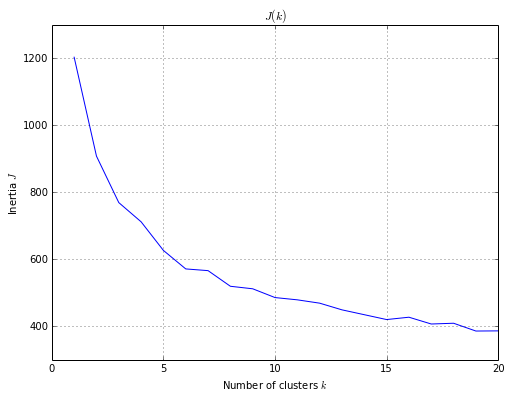

In [9]:
ks = range(1, 21)
inertias = np.zeros(len(ks))

for i, k in enumerate(ks):
    cls = Clustering(k)
    y = cls.fit_predict(x)
    inertias[i] = quality(x, y)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, inertias)
pl.title("$J(k)$")
pl.ylabel("Inertia $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE

In [10]:
k = 5
cls = Clustering(k)
y = cls.fit_predict(x)

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png))

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 2999
[t-SNE] Computed conditional probabilities for sample 2000 / 2999
[t-SNE] Computed conditional probabilities for sample 2999 / 2999
[t-SNE] Mean sigma: 0.137819
[t-SNE] Error after 83 iterations with early exaggeration: 19.515181
[t-SNE] Error after 321 iterations: 1.982955


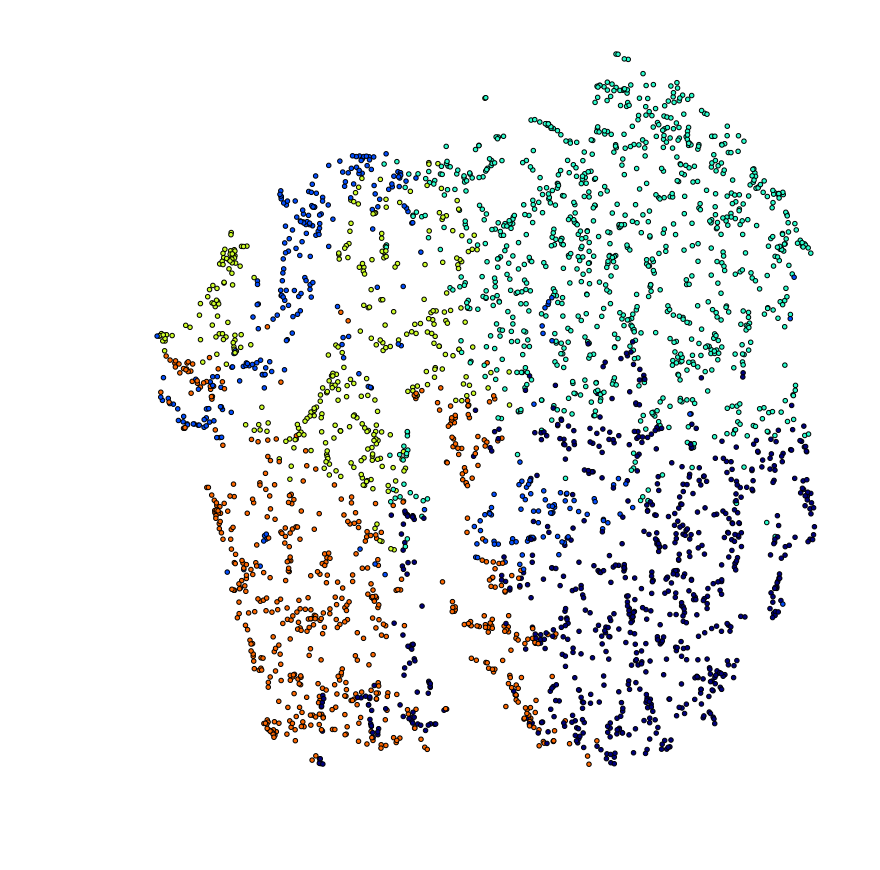

In [14]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Реализация радара:
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

/usr/lib/pymodules/python2.7/matplotlib/cbook.py:1711: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = np.zeros(new_shape, a.dtype)


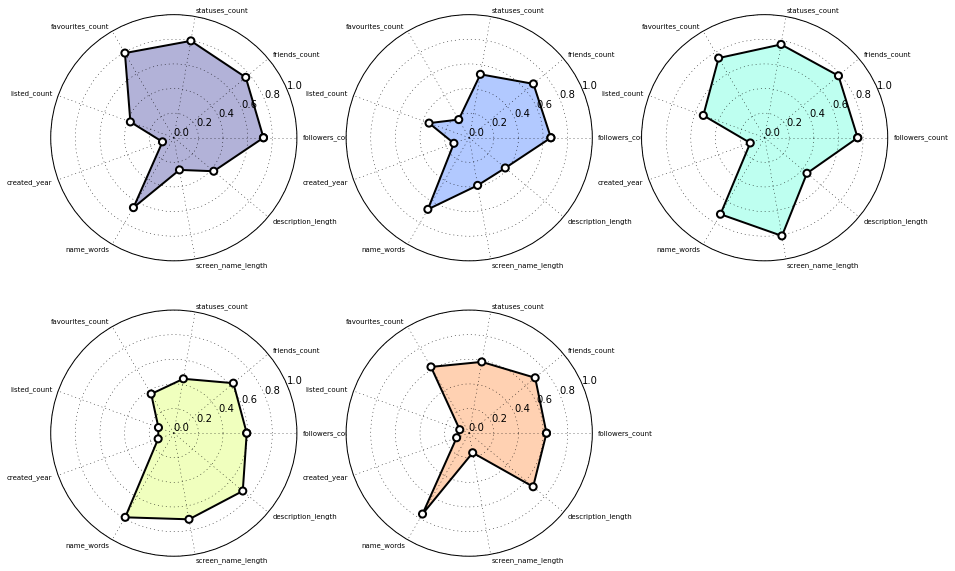

In [13]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()